In [9]:
import faiss
import torch 

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from tqdm import tqdm
import yaml

parameters = yaml.safe_load(open("/home/felipe/Projects/roco-image-captioning/config.yaml"))
from pprint import pprint

pprint(parameters)

from src.lib.dataset.ROCODataset_withKeywords import ImageTextDataset_withKeywords
from src.lib.dataset.ROCODataset import ImageTextDataset

from src.lib.data_transform.collate import collate_clip

{'dataset': {'test_json': '/home/felipe/Projects/roco-image-captioning/roco-dataset/json/test_dataset.json',
             'train_json': '/home/felipe/Projects/roco-image-captioning/roco-dataset/json/train_dataset.json',
             'validation_json': '/home/felipe/Projects/roco-image-captioning/roco-dataset/json/validation_dataset.json'},
 'input_size': [224, 224],
 'optimizer': {'lr': 1e-05,
               'lr_scheduler_patience': 1,
               'lr_scheduler_rate': 0.1,
               'method': 'adam',
               'weight_decay': 0.0005},
 'registry': {'checkpoints_dir': 'outputs/model_checkpoints',
              'name': 'roco-clip',
              'project': 'roco-debug',
              'wandb_root_dir': 'outputs/wandb_outputs'},
 'train': {'batch_size': 64,
           'early_stopping_patience': 5,
           'gradient_clip_val': 10.0,
           'limit_train_batches': 1.0,
           'log_every_n_steps': 4,
           'max_epochs': 10,
           'max_seq_length': 140}}


In [11]:
from transformers import CLIPProcessor

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [12]:
from src.lib.model.clip import MedCLIP

model = MedCLIP.load_from_checkpoint(
    "/home/felipe/Projects/roco-image-captioning/outputs/model_checkpoints/last-v3.ckpt",
    strict=False, map_location=torch.device('cpu'))

In [39]:
SHUFFLE = False
MAX_SAMPLES = 10000

In [40]:
print("Loading test data...")
start = time.perf_counter()
test_data = ImageTextDataset(
    "test", cfg=parameters,
)
print(f"Successfully loaded test data! Elapsed: {time.perf_counter() - start:.1f} seconds")

test_dataloader = torch.utils.data.DataLoader(
    batch_size=1,
    dataset=test_data,
    shuffle=SHUFFLE,
    num_workers=4,
    drop_last=True,
    collate_fn=collate_clip,
)


Loading test data...
Successfully loaded test data! Elapsed: 0.0 seconds


In [41]:
print("Loading train data...")
start = time.perf_counter()
train_data = ImageTextDataset(
    "train", cfg=parameters,
)
print(f"Successfully loaded train data! Elapsed: {time.perf_counter() - start:.1f} seconds")

train_dataloader = torch.utils.data.DataLoader(
    batch_size=1,
    dataset=train_data,
    shuffle=SHUFFLE,
    num_workers=4,
    drop_last=True,
    collate_fn=collate_clip,
)


Loading train data...
Successfully loaded train data! Elapsed: 0.2 seconds


In [43]:
info = {
    "train": train_dataloader,
    "test": test_dataloader,
}

for name, dl in info.items():
    text_embeds_database = []
    
    for inputs in tqdm(dl):
        text_features, image_features = model.extract_features(inputs)
        text_embeds_database.append(text_features.detach().numpy().squeeze())
    
        if len(text_embeds_database) > MAX_SAMPLES:
            break
            
    text_embeds_database = text_embeds_database[:MAX_SAMPLES]
    
    text_embeds_database = np.array(text_embeds_database)
    print(name, text_embeds_database.shape)
    
    # Save the array to a .npy file
    np.save(f'text_embeds_database_{name}.npy', text_embeds_database)

 15%|█▌        | 10000/65391 [17:32<1:37:09,  9.50it/s]


train (10000, 512)


100%|██████████| 8172/8172 [13:35<00:00, 10.03it/s]

test (8172, 512)


In [45]:
db = np.load('text_embeds_database_train.npy')
# db = np.load('text_embeds_database_test.npy')
 
print("Loaded data:", db.shape)

Loaded data: (10000, 512)


In [46]:
samples, d = db.shape
print(f"Number of samples: {samples}")
print(f"Embedding dimension: {d}")
index = faiss.IndexFlatL2(d) 
print(index.is_trained)
index.add(db)                  # add vectors to the index
print(index.ntotal)

Number of samples: 10000
Embedding dimension: 512
True
10000


In [47]:
import textwrap

train
Number of samples: 10000
Embedding dimension: 512
True
10000


  0%|          | 0/65391 [00:00<?, ?it/s]

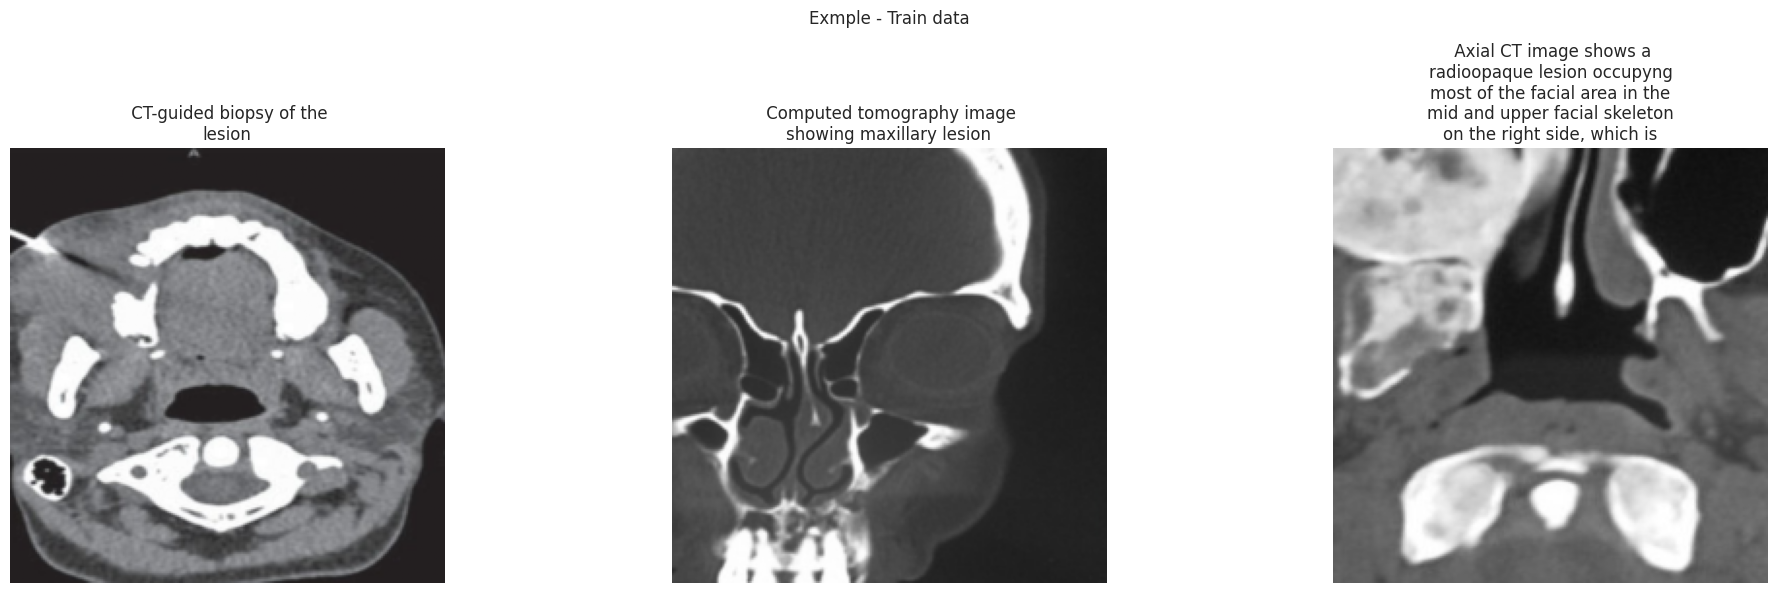

 15%|█▌        | 10000/65391 [17:20<1:36:03,  9.61it/s]


Accuracy (train):  0.00 %
Accuracy2 (train):  26.93 %
Cosine Similarity (train):  0.357 +-  0.031
test
Number of samples: 8172
Embedding dimension: 512
True
8172


  0%|          | 0/8172 [00:00<?, ?it/s]

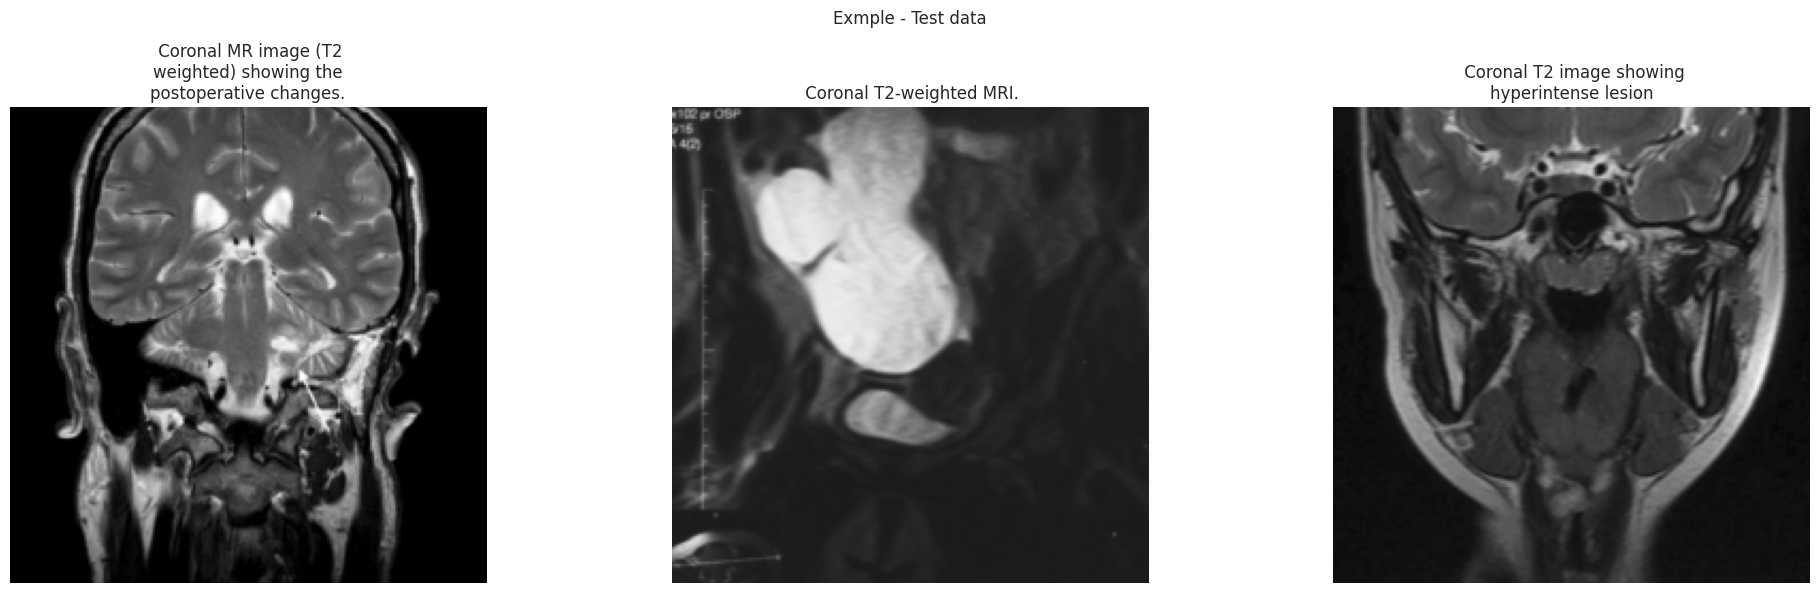

100%|██████████| 8172/8172 [13:46<00:00,  9.89it/s]

Accuracy (test):  0.00 %
Accuracy2 (test):  7.89 %
Cosine Similarity (test):  0.348 +-  0.032


In [60]:
KNN = 3                          # number of nearest neighbors (in the paper they compute with k=1, but here I want to peek at some more distant neighbors)
eps = 1e-6
plot_first_example = True
info_plots = {
    "train": train_data,
    "test": test_data,
}

for name, dl in info.items():
    
    db = np.load(f'text_embeds_database_{name}.npy')
    faiss.normalize_L2(db)           # Normalize INPLACE beforehand for cosine sim

    samples, d = db.shape
    print(name)
    print(f"Number of samples: {samples}")
    print(f"Embedding dimension: {d}")
    index = faiss.IndexFlatIP(d)   # Setting up cosine sim metric 
    print(index.is_trained)
    index.add(db)                  # add vectors to the index
    print(index.ntotal)
    
    cosine_sims = []
    accuracy = 0       # Computed by checking if cos sim is unitary = 1 with tolerance eps 
    accuracy2 = 0      # Computed by matching index to expected (assumes no shuffle, batch_size=1, and dataset is traversed sequentially 0,1,2...)
    first_example = True
    
    correct_index = 0
    for inputs in tqdm(dl):
        if correct_index >= MAX_SAMPLES:
            break
            
        text_features, image_features = model.extract_features(inputs)
        
        visual_query = image_features.detach().numpy().squeeze()
        visual_query = visual_query[np.newaxis, ...]
        faiss.normalize_L2(visual_query)  # Normalize INPLACE beforehand for cosine sim
        
        D, I = index.search(visual_query, KNN)  # Search for max. cosine sim
        # print("KNNs", I.shape, I)
        # print("Cosine similarities: ", D.shape, D)
        
        if abs(D[0, 0] - 1.0) < eps:   # Hits
            accuracy += 1
        
        if I[0, 0] == correct_index:
            accuracy2 += 1
            
        cosine_sims.append(D[0, 0])
        
        if plot_first_example and first_example:
            
            
            fig, axs = plt.subplots(1, KNN, figsize=(20, 6))
            for j in range(KNN):
                sample = I[0, j]
                image, target = info_plots[name][sample]
                image = np.transpose(image, (1, 2, 0))
                wrapped_title = "\n".join(textwrap.wrap(target, width=30))
                axs[j].imshow(image)
                axs[j].axis("off")
                #########################
                axs[j].set_title(wrapped_title)
                axs[j].set_xlabel(f"Neighbor #{j+1}")
                
            fig.suptitle(f"Exmple - {name.capitalize()} data")
            fig.tight_layout()
            plt.show()
            first_example = False
        
        correct_index += 1
        
    accuracy = accuracy / samples
    accuracy2 = accuracy2 / samples
    cosine_sims = np.array(cosine_sims)
    print(f"Accuracy ({name}):  {accuracy * 100 :.2f} %")
    print(f"Accuracy2 ({name}):  {accuracy2 * 100 :.2f} %")
    print(f"Cosine Similarity ({name}):  {cosine_sims.mean() :.3f} +-  {2*cosine_sims.std() :.3f}")


    